The calculations of loss during the training of networks can use weighting to reinforce the learning of specific variables and features in data. In order to reinforce physically reasonable predictions, you can impose more strict penalties for predictions in physically invalid predictions. For example, a prediction of Power Conversion Efficiency (PCE) above the Schockley-Quassier predicted maximum PCE could increase exponentially, rather than linearly.

The classes developed below are wrappers for PyTorch tensors loss functions, which additionally modify these classes using theoretically and emprically derived boundaries for network loss calculations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_total_df.xlsx')
print (device_df.shape)
device_df.head()

(108, 20)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0,15,100,4,2,17.194652,29.172066,8.554721,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003245,352.677591,1,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,13.709728,14.635628,6.938374,7.985216,0.824877,0.138410,-0.205623,1.075388,48.559552,98.492589,1,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,18.211098,21.013541,8.857453,10.356933,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456627,1,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,19.640309,46.935628,9.781374,26.994708,0.857443,0.105577,-0.331902,0.940640,236.482362,1306.085256,1,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,20.647291,35.791550,8.412561,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148913,1,2.710602,0.568631,7.328048,65.04993


In [14]:
# Hyper parameters
num_epochs = 25
batch_size = int(len(device_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.004

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [71]:
X = device_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MajorAL_stdev', 'MinorAL_avg',
              'MinorAL_stdev', 'Ecc_avg', 'Ecc_stdev', 'Orient_avg', 'Orient_stdev', 'Perim_avg',
              'Perim_stdev', 'GMM_label']] #input features used to make prediction
Y = device_df[['PCE']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

#convert pd.DataFrame -> np.ndarray -> torch.tensor
x_train_tensor = torch.tensor(x_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))


train_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, shuffle = True)

In [72]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus()
        )
        self.outlayer = nn.Linear(16, 1)

        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        
        #embedded data is passed to output layer
        out = self.PCE_branch(out)
        out= self.outlayer(out)
        
        return out

In [73]:
def train_model(model, training_data_set, optimizer):
    epoch_losses = []    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    criterion = ThresholdedMSELoss(lower = 0, upper = 6)
#     criterion = nn.MSELoss()
    
    for train_data, labels in training_data_set:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        out = model(train_data) #gather model predictions for this loop
        
        #calculate batch loss and accuracy in the predictions
        batch_loss = criterion(out, labels)

        #BACKPROPOGATE LIKE A MF
        torch.autograd.backward(batch_loss)
        optimizer.step()
        
        #save loss and accuracy for this batch
        epoch_losses.append(batch_loss.item())
        train_total+=1
        
    #calculate and save total error and accuracy for this epoch of training
    epoch_loss = sum(epoch_losses)/train_total

    
    #update progress bar
    print(f'Epoch training loss: {epoch_loss}')
    
    return epoch_loss

In [74]:
def eval_model(model, testing_data_set):
    #evaluate the model
    model.eval()
    
    criterion = ThresholdedMSELoss(lower = 0, upper = 6)
#     criterion = nn.MSELoss()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        
        epoch_losses = []
        test_total = 0

        for inputs, labels in testing_data_set:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

    
            # calculate loss per batch of testing data
            test_loss = criterion(outputs, labels)
            epoch_losses.append(test_loss.item())

            test_total += 1 
            
        # Average all batches in Epoch
        test_epoch_loss = sum(epoch_losses)/test_total

        print(f"Epoch testing loss = {test_epoch_loss}")
    
    return test_epoch_loss

In [75]:
def model_validation(model, validation_data_set):
    #evaluate the model
    model.eval()
    
    criterion = ThresholdedMSELoss(lower = 0, upper = 6)
#     criterion = nn.MSELoss()
    accuracy = MAPE()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        
        val_losses = []
        val_accuracies = []

        for inputs, labels in validation_data_set:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

    
            # calculate loss per batch of testing data
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
            
            val_acc = accuracy(outputs, labels)
            val_accuracies.append(val_acc.item())
    
    return val_losses, val_accuracies

In [76]:
class ThresholdedMSELoss(nn.Module):
    """
    This class contains a loss function that use a mean-squared-error loss for reasonable predictions
    and an exponential penalty for unreasonable predictions. They inherit from torch.nn.Module. For 
    physically unreasonable conditions, prediction loss is more severely calculated. What qualifies as
    reasonable is based on empirically gathered datasets and literature reported boundaries of performance.
    
    For the following predictions that are improbable, the loss is penalized:
    - X < lower
    - X > upper
    """

    def __init__(self, lower, upper):
        super(ThresholdedMSELoss, self).__init__()
        self.lower = lower
        self.upper = upper

    def forward(self, predictions, labels):
#         print (predictions.size())
#         print (labels.size())
        
        result_list = torch.zeros(predictions.size(0))
        element_count = 0
        
        for x, y in zip(predictions, labels):
#             print (f"{el_count+1}/{result_list.size(0)}")
            
            # if (x >= 0) == 1 (True)
            if torch.le(x, torch.tensor([self.lower])) == torch.tensor([1]):
                #Exponential MSE for x <= 0
#                 print(f"prediction = {x}, lower threshold violated")

                # Need to use only torch.nn.Function() and torch.() functions for autograd to track operations
                error = torch.add(x, torch.neg(y)) #error = x + (-y)
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 1)
            

           # if (x <= 6) == 1 (True)
            elif torch.ge(x, torch.tensor([self.upper])) == torch.tensor([1]):
                #exponential MSE for x >= 6
#                 print(f"prediction = {x}, upper threshold violated")

                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 1)

                # all other values of x
            else:
#                 print(f"prediction = {x}")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                
            result_list[element_count] = element_result
            element_count+=1
            
            
            # Average of all the squared errors
            result = result_list.mean()

            return result


In [77]:
class Accuracy(nn.Module):
    """
    Simple class to interate through predictions and labels to determine overall accuracy of a model
    """
    
    def __init__(self, acc_thresh = 0.1):
        super(Accuracy, self).__init__()
        self.acc_thresh = acc_thresh
        
    def forward(self, predictions, labels):
        element_count = 0
        correct = 0
        
        accuracy_list = []
        
        for x, y in zip(predictions, labels):
            
            error = torch.tensor(x-y)
            
            #if precision <= accuracy threshold, count as correct
            if torch.le(torch.div(error, y), torch.tensor(self.acc_thresh)) == torch.tensor([1]):
                correct += 1
                element_count += 1

            else:
                element_count += 1
            
            accuracy = (correct/element_count) * 100
            accuracy_list.append(accuracy)
            
        acc_list = torch.tensor(accuracy_list)
            
        avg_acc = acc_list.mean()

        return avg_acc

In [88]:
class MAPE(nn.Module):
    """
    Simple class to interate through pytorch tensors of predictions and ground-tuths to calculate 
    the Mean Absolute Percent Error (MAPE).
    """
    
    def __init__(self):
        super (MAPE, self).__init__()
        
    def forward(self, predictions, labels):
        
        absolute_percent_error_list = []
        count = 0
        
        for x, y in zip(predictions, labels):
            count += 1
            
            error = y - x
            
            ae = np.absolute(error)
            
            ape = ae/y
            
            absolute_percent_error_list.append(ape)
            
        mape = np.sum(absolute_percent_error_list) / count
        mape = mape * 100
        
        return mape

In [89]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = NN1(in_dims = in_dims, out_dims = out_dims).to(device)
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [90]:
#empty lists to hold loss per epoch
train_epoch_losses = []
test_epoch_losses = []


for epoch in range(num_epochs):

    train_epoch_loss = train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    
    test_epoch_loss = eval_model(model = model, testing_data_set = testing_data_set)
    test_epoch_losses.append(test_epoch_loss)

Epoch training loss: 0.014826077967882156
Epoch testing loss = 4.442003640092232
Epoch training loss: 0.1418307377025485
Epoch testing loss = 4.571417579787191
Epoch training loss: 0.028224419569596648
Epoch testing loss = 2.9449047554622996
Epoch training loss: 0.019159621937433258
Epoch testing loss = 1.7639425744048574
Epoch training loss: 0.010382239241153002
Epoch testing loss = 1.2182571894743226
Epoch training loss: 0.9186783274053596
Epoch testing loss = 0.382304759696126
Epoch training loss: 0.01763280970044434
Epoch testing loss = 0.23313438600267877
Epoch training loss: 0.015372638146800455
Epoch testing loss = 0.27387532269693277
Epoch training loss: 0.01666504656895995
Epoch testing loss = 0.2671317365814254
Epoch training loss: 0.012606604141183197
Epoch testing loss = 0.2145204400982369
Epoch training loss: 0.013546077301725745
Epoch testing loss = 0.16096314618533308
Epoch training loss: 0.0020434643956832588
Epoch testing loss = 0.13206957833079452
Epoch training loss:

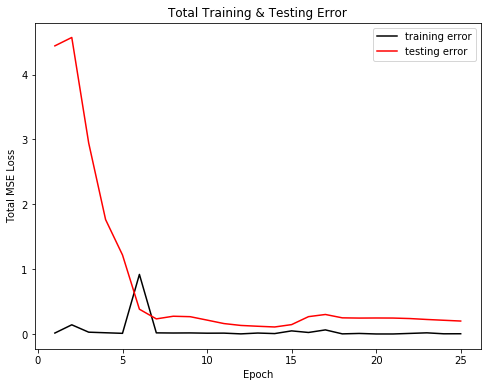

In [91]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

In [92]:
final_losses, final_accuracies = model_validation(model = model, validation_data_set = testing_data_set)

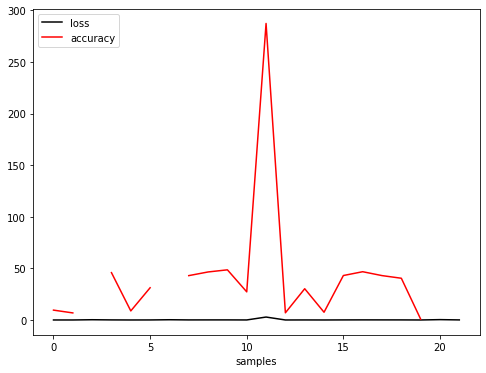

In [103]:
fig, ax = plt.subplots(figsize = (8,6))

samples = np.arange(0, len(final_accuracies), 1)

plt.plot(samples, final_losses, c = 'k', label = 'loss')
plt.plot(samples, final_accuracies, c = 'r', label = 'accuracy')
ax.set_xlabel('samples')
plt.legend(loc = 'upper left')
plt.show()

In [94]:
final_accuracies

[9.54955518245697,
 6.8366073071956635,
 inf,
 45.85774838924408,
 8.769463002681732,
 31.21742308139801,
 inf,
 42.96657145023346,
 46.517035365104675,
 48.57890009880066,
 27.23900079727173,
 287.2661590576172,
 6.950797140598297,
 30.267560482025146,
 7.500264048576355,
 43.06052327156067,
 46.75331115722656,
 42.99355745315552,
 40.43140709400177,
 0.8241184055805206,
 inf,
 43.30015778541565]

In [95]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in testing_data_set:
        
        inputs.to(device)
        labels.to(device)
        
        outputs = model(inputs)
        
        predictions.append(outputs.item())
        targets.append(labels.item())


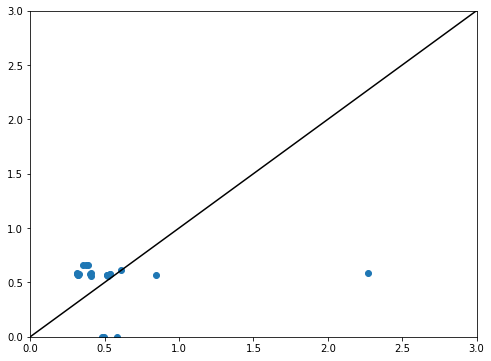

In [106]:
xlin = ylin = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize = (8,6))

plt.scatter(predictions, targets)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.show()